In [20]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import json

import analysis_helpers as h
reload(h)

## get standardized object list
categories = ['bird','car','chair','dog']
obj_list = []
for cat in categories:
    for i,j in h.objcat.iteritems():
        if j==cat:
            obj_list.append(i)        

In [2]:
# directory & file hierarchy
iterationName = 'pilot2'
exp_path = './'
analysis_dir = os.getcwd()
data_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','data',exp_path))
exp_dir = './'
sketch_dir = os.path.abspath(os.path.join(os.getcwd(),'../../..','analysis',exp_path,'sketches','pilot2'))

In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['sketchpad_basic_recog']

stimdb = conn['stimuli']
stimcoll = stimdb['sketchpad_basic_pilot2_sketches']

In [4]:
## How many sketches have been retrieved at least once? equivalent to: coll.find({'numGames':{'$exists':1}}).count()
x = stimcoll.find({'numGames':{'$gte':0}}).count()
y = coll.count()
print '{} sketches in the stimuli db that have been retrieved at least once'.format(x)
print '{} records in the recognition experiment database'.format(y)

2849 sketches in the stimuli db that have been retrieved at least once
7724 records in the recognition experiment database


In [5]:
len(coll.find({'iterationName': {'$in': ['pilot0', 'pilot1']}}).distinct('wID'))


112

### preprocess recognition task data

In [ ]:
## retrieve records from db
## notes: 
## pilot0 = no feedback onscreen
## pilot1 = bonus point counter onscreen

a = coll.find({'iterationName': {'$in': ['pilot0', 'pilot1']}}).sort('gameID')

## make lists from db
gameID = []
target = []
choice = []
correct = []
correct_class = []
rt = []
fname = []

d1 = []
d2 = []
d3 = []
target_category = []
chosen_category = []
condition = []
drawDuration = []
original_gameID = []
viewer_correct = []
viewer_choice = []
viewer_RT = []
mean_intensity = []
num_strokes = []

bad_sessions = ['1571-00d11ddf-96e7-4aae-ba09-1a338b328c0e','9770-2f360e9a-7a07-4026-9c36-18b558c1da21']

counter = 0
for rec in a:
    if rec['gameID'] not in bad_sessions:
        try:
            if counter%500==0:
                print '{} out of {} records analyzed.'.format(counter,a.count())
            if rec['target'] is not None:
                gameID.append(rec['gameID'])
                target.append(rec['target'])
                choice.append(rec['choice'])
                correct.append(rec['correct'])
                rt.append(rec['rt'])
                f = rec['sketch'].split('/')[-1]
                fname.append(f)
                chosen_category.append(h.objcat[rec['choice']])

                ## match up with corresponding record in stimuli collection
                b = stimcoll.find({'fname_no_target':f})[0]
                assert stimcoll.find({'fname_no_target':f}).count()==1
                d1.append(b['Distractor1'])
                d2.append(b['Distractor2'])
                d3.append(b['Distractor2'])
                target_category.append(b['category'])
                correct_class.append(h.objcat[rec['choice']]==b['category'])
                condition.append(b['condition'])
                drawDuration.append(b['drawDuration'])
                original_gameID.append(b['gameID'])
                viewer_correct.append(b['outcome'])
                viewer_choice.append(b['response'])
                viewer_RT.append(b['viewerRT'])
                mean_intensity.append(b['mean_intensity'])  
                num_strokes.append(b['numStrokes'])    
                counter += 1
        except:
            print 'Something went wrong with {} {}'.format(rec['gameID'],rec['trialNum'])
            pass

In [191]:
## organize data into dataframe
X = pd.DataFrame([gameID,target,choice,correct,rt,fname,d1,d2,d3,target_category,chosen_category,condition,drawDuration, \
                 original_gameID,viewer_correct,viewer_choice,viewer_RT,mean_intensity,num_strokes,correct_class])
X = X.transpose()
X.columns = ['gameID','target','choice','correct','rt','fname','d1','d2','d3','target_category','chosen_category','condition','drawDuration', \
            'original_gameID','viewer_correct','viewer_choice','viewer_RT','mean_intensity','num_strokes','correct_class']
print '{} annotations saved.'.format(X.shape[0])

In [186]:
## remove NaN rows from data matrix (no target recorded)
X = X[X['target'].isin(obj_list)]

## filter out responses that took too long, or too short
too_fast = 1000
too_slow = 20000
X = X[(X['rt']>=too_fast) & (X['rt']<=too_slow)]

print '{} annotations retained.'.format(X.shape[0])

7017 annotations retained.


In [192]:
## save out to CSV
X.to_csv('./sketchpad_basic_recog_group_data.csv')

### basic performance measures 

In [6]:
## load in CSV
X = pd.read_csv('./sketchpad_basic_recog_group_data.csv')

In [7]:
if not os.path.exists('./plots'):
    os.makedirs('./plots')

In [8]:
## how many sessions (proxy for number of observers) do we have?
print 'Number of sessions: {}'.format(len(np.unique(X.gameID.values)))

Number of sessions: 137


In [9]:
## what is object-level accuracy broken out condition?
print X.groupby('condition')['correct'].apply(lambda x: np.mean(x))

## what is class-level accuracy?
print X.groupby('condition')['correct_class'].apply(lambda x: np.mean(x))


condition
closer     0.541994
further    0.374720
Name: correct, dtype: float64
condition
closer     0.980238
further    0.978188
Name: correct_class, dtype: float64


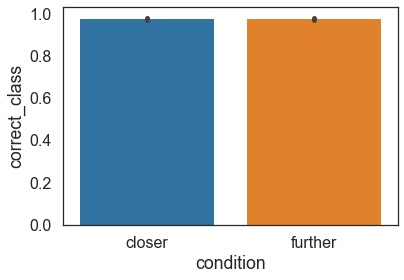

In [130]:
sns.barplot(x='condition',
            y='correct_class',
           data=X)

In [10]:
print X.groupby('condition')['rt'].apply(lambda x: np.median(x))

condition
closer     4052.0
further    4131.5
Name: rt, dtype: float64


In [125]:
# X.groupby(['gameID','condition'])['correct'].apply(lambda x: np.mean(x))
# X.groupby(['gameID'])['correct'].apply(lambda x: np.mean(x))

In [11]:
## plot accuracy by condition and game (individual differences)
#X.groupby(['gameID','condition'])['correct'].apply(lambda x: np.mean(x))

## subset by full games only
all_games = np.unique(X.gameID.values)
full_games = [i for i in all_games if np.sum(X['gameID']==i)>50]
_X = X[X['gameID'].isin(full_games)]

game_acc_close = _X[_X['condition']=='closer'].groupby('gameID')['correct'].apply(lambda x: np.mean(x))
game_acc_far = _X[_X['condition']=='further'].groupby('gameID')['correct'].apply(lambda x: np.mean(x))
fig = plt.figure(figsize=(6,6))
plt.scatter(game_acc_close,game_acc_far)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],linestyle='dashed')
plt.title('accuracy by condition and game')
plt.xlabel('close accuracy')
plt.ylabel('far accuracy')
plt.savefig('./plots/accuracy_by_condition_and_game.pdf')
plt.close(fig)

In [12]:
## overall accuracy by category
fig = plt.figure(figsize=(6,6))
sns.barplot(x='target_category',y='correct',data=X)
plt.xlabel('category')
plt.ylabel('accuracy')
plt.title('accuracy by category')
plt.ylim([0,1])
plt.savefig('./plots/accuracy_by_category.pdf')
plt.close(fig)

In [13]:
objs = np.unique(X['target'].values)
objs = [o for o in objs if o is not None]
obj_acc_close = X[X['condition']=='closer'].groupby('target')['correct'].apply(lambda x: np.mean(x))
obj_acc_far = X[X['condition']=='further'].groupby('target')['correct'].apply(lambda x: np.mean(x))
fig = plt.figure(figsize=(12,12))
plt.scatter(obj_acc_close,obj_acc_far)
for i, txt in enumerate(objs):
    plt.annotate(txt, (obj_acc_close[i],obj_acc_far[i]))
plt.xlim([-0.1,1])
plt.ylim([-0.1,1]) 
plt.plot([0,1],[0,1],linestyle='dashed')
plt.xlabel('close accuracy')
plt.ylabel('far accuracy')
plt.title('accuracy by condition and object')
plt.savefig('./plots/accuracy_by_condition_and_object.pdf')
plt.close(fig)

In [14]:
objs = np.unique(X['target'].values)
objs = [o for o in objs if o is not None]
obj_acc_close = X[X['condition']=='closer'].groupby('target')['rt'].apply(lambda x: np.mean(x))
obj_acc_far = X[X['condition']=='further'].groupby('target')['rt'].apply(lambda x: np.mean(x))
fig = plt.figure(figsize=(12,12))
plt.scatter(obj_acc_close,obj_acc_far)
for i, txt in enumerate(objs):
    plt.annotate(txt, (obj_acc_close[i],obj_acc_far[i]))
plt.xlim([0,20000])
plt.ylim([0,20000])
plt.plot([0,20000],[0,20000],linestyle='dashed')
plt.xlabel('close RT')
plt.ylabel('far RT')
plt.title('RT by condition and object')
plt.savefig('./plots/RT_by_condition_and_object.pdf')
plt.close(fig)

In [15]:
## subset by full games only
all_games = np.unique(X.gameID.values)
full_games = [i for i in all_games if np.sum(X['gameID']==i)>50]
_X = X[X['gameID'].isin(full_games)]

game_acc_close = _X[_X['condition']=='closer'].groupby('gameID')['rt'].apply(lambda x: np.median(x))
game_acc_far = _X[_X['condition']=='further'].groupby('gameID')['rt'].apply(lambda x: np.median(x))
fig = plt.figure(figsize=(6,6))
plt.scatter(game_acc_close,game_acc_far)
# plt.xlim([0,20000])
# plt.ylim([0,20000])
# plt.plot([0,20000],[0,20000],linestyle='dashed')
plt.title('RT by condition and game')
plt.xlabel('close RT')
plt.ylabel('far RT')
plt.savefig('./plots/RT_by_condition_and_game.pdf')
plt.close(fig)

In [185]:
## subset by full games only
all_games = np.unique(X.gameID.values)
full_games = [i for i in all_games if np.sum(X['gameID']==i)>50]
_X = X[X['gameID'].isin(full_games)]

acc = _X.groupby('gameID')['correct'].apply(lambda x: np.mean(x))
rt = _X.groupby('gameID')['rt'].apply(lambda x: np.mean(x))
fig = plt.figure(figsize=(6,6))
plt.scatter(acc,rt)
plt.xlabel('accuracy')
plt.ylabel('RT')
plt.title('RT vs. accuracy by game')
plt.savefig('./plots/RT_vs_accuracy_by_game.pdf')
plt.close(fig)

In [171]:
# Y = X.groupby(['target','condition'])['correct'].apply(lambda x: np.mean(x))

### make confusion matrix

In [16]:
import analysis_helpers as h
reload(h)

## get standardized object list
categories = ['bird','car','chair','dog']
obj_list = []
for cat in categories:
    for i,j in h.objcat.iteritems():
        if j==cat:
            obj_list.append(i)        

##### all sketches

In [17]:
## initialize confusion matrix
confusion = np.zeros((len(obj_list),len(obj_list)))

## generate confusion matrix by incrementing in each cell
for i,d in X.iterrows():
    targ_ind = obj_list.index(d['target'])
    choice_ind = obj_list.index(d['choice'])
    confusion[targ_ind,choice_ind] += 1
    
## normalized confusion matrix    
normed = np.zeros((len(obj_list),len(obj_list)))
for i in np.arange(len(confusion)):
    normed[i,:] = confusion[i,:]/np.sum(confusion[i,:])    
    
## plot confusion matrix
from matplotlib import cm
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.matshow(normed,vmin=0,vmax=1,cmap=cm.viridis)
plt.xticks(range(len(normed)), obj_list, fontsize=12,rotation='vertical')
plt.yticks(range(len(normed)), obj_list, fontsize=12)
plt.colorbar(cax,shrink=0.8)
plt.tight_layout()
plt.savefig('./plots/confusion_matrix_all.pdf')
plt.close(fig)

##### divided by condition

In [18]:
conds = ['closer','further']

for cond in conds:
    ## initialize confusion matrix 
    confusion = np.zeros((len(obj_list),len(obj_list)))

    _X = X[X['condition']==cond]
    ## generate confusion matrix by incrementing in each cell
    for i,d in _X.iterrows():
        targ_ind = obj_list.index(d['target'])
        choice_ind = obj_list.index(d['choice'])
        confusion[targ_ind,choice_ind] += 1

    ## normalized confusion matrix    
    normed = np.zeros((len(obj_list),len(obj_list)))
    for i in np.arange(len(confusion)):
        normed[i,:] = confusion[i,:]/np.sum(confusion[i,:])    

    ## plot confusion matrix
    from matplotlib import cm
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    cax = ax.matshow(normed,vmin=0,vmax=1,cmap=cm.viridis)
    plt.xticks(range(len(normed)), obj_list, fontsize=12,rotation='vertical')
    plt.yticks(range(len(normed)), obj_list, fontsize=12)
    plt.colorbar(cax,shrink=0.8)
    plt.tight_layout()
    plt.savefig('./plots/confusion_matrix_{}.pdf'.format(cond))
    plt.close(fig)

##### plot difference between close and far conditions

In [19]:
conds = ['closer','further']
normed = np.zeros((len(obj_list),len(obj_list),2))

for k,cond in enumerate(conds):
    ## initialize confusion matrix 
    confusion = np.zeros((len(obj_list),len(obj_list)))

    _X = X[X['condition']==cond]
    ## generate confusion matrix by incrementing in each cell
    for i,d in _X.iterrows():
        targ_ind = obj_list.index(d['target'])
        choice_ind = obj_list.index(d['choice'])
        confusion[targ_ind,choice_ind] += 1

    ## normalized confusion matrix    
    for i in np.arange(len(confusion)):
        normed[i,:,k] = confusion[i,:]/np.sum(confusion[i,:])    

## plot difference in confusion matrix
from matplotlib import cm
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.matshow(normed[:,:,0]-normed[:,:,1],vmin=-0.2,vmax=0.2,cmap=cm.BrBG)
plt.xticks(range(len(normed)), obj_list, fontsize=12,rotation='vertical')
plt.yticks(range(len(normed)), obj_list, fontsize=12)
plt.colorbar(cax,shrink=0.8)
plt.tight_layout()
plt.savefig('./plots/confusion_matrix_close_minus_far.pdf')
plt.close(fig)

# save out to npy 
np.save('./human_confusion.npy',normed)

#### prep jsons for evaluation by passing forward to RSA

Format for json is a dictionary of dictionaries, where each top-level key refers to one of the renders, e.g. "trial_20_cuckoo". For each render, you can look up the similarity with each sketch, referenced with an abbreviated ID taken by trimming the last 12-character string, and appending an underscore, and the trial number. E.g., 'gameID_9903-d6e6a9ff-a878-4bee-b2d5-26e2e239460a_trial_9.npy' ==> '26e2e239460a_9'

In [23]:
import json

## sample json paths
json_path_prefix = '../models/refModule/json/'
json_file = 'strict-similarity-pragmatics-fixedpose-augmented-splitbycontext_conv4_2.json'
json_path = os.path.join(json_path_prefix,json_file)

def load_json(json_path):
    with open(json_path) as fp:
        data = json.load(fp)  
    return data

## build dictionary to look up the appropriate render ID to use to associate with each sketch
data = load_json(json_path)
    
obj_to_render = dict(zip([i.split('_')[-1] for i in data.keys()], data.keys()))  
render_to_obj = dict(zip(data.keys(),[i.split('_')[-1] for i in data.keys()]))  

In [24]:
def simplify_sketch(path): ## example path: 'gameID_9903-d6e6a9ff-a878-4bee-b2d5-26e2e239460a_trial_9.npy' ==> '26e2e239460a_9'
    path = '_'.join(os.path.splitext(os.path.basename(path))[0].split('_')[1:])
    path = path.split('-')[-1]
    path = path.replace('_trial', '')
    return path

def add_simplified_ids(X):
    ## add renderID and sketchID to dataframen
    renderID = []
    sketchID = []
    for i,d in X.iterrows():
        renderID.append(obj_to_render[d['target']])
        sketchID.append(simplify_sketch(d['fname']))
    X['renderID'] = renderID
    X['sketchID'] = sketchID    
    return X

In [25]:
## add simplified id's
X = add_simplified_ids(X)

## save out again to csv with these additional columns added
X.to_csv('./sketchpad_basic_recog_group_data_augmented.csv')

## load in normalized confusion matrix
confusion = np.load('./human_confusion.npy')
close_con = confusion[:,:,0]
far_con = confusion[:,:,1]

In [26]:
## get confusion matrix lookup table for sketches from each condition

## close
rows = [i for i in close_con]
close_lookup = dict(zip(obj_list, [dict(zip(obj_list,r)) for r in rows])) 

## far
rows = [i for i in far_con]
far_lookup = dict(zip(obj_list, [dict(zip(obj_list,r)) for r in rows])) 

## list of 3d rendered objects
render_list = data.keys()

In [342]:
## generate big json dictionary of dictionaries
out_json = {}
for i,this_render in enumerate(render_list):
    print i, this_render
    out_json[this_render] = {}
    for i,d in X.iterrows():
        if d['condition'] == 'closer':
            which_dict = close_lookup
        elif d['condition'] == 'further':
            which_dict = far_lookup
        this_sketch = d['sketchID']
        this_target = d['target']
        similarity = which_dict[this_target][render_to_obj[this_render]]
        out_json[this_render][this_sketch] = similarity

0 trial_12_bluejay
1 trial_7_basset
2 trial_2_bullmastiff
3 trial_30_doberman
4 trial_10_beetle
5 trial_11_waiting
6 trial_1_bluesport
7 trial_31_bluesedan
8 trial_4_straight
9 trial_8_knob
10 trial_15_nightingale
11 trial_22_leather
12 trial_24_white
13 trial_28_chihuahua
14 trial_17_redsport
15 trial_29_sparrow
16 trial_21_woven
17 trial_25_goldenretriever
18 trial_32_squat
19 trial_3_redantique
20 trial_9_brown
21 trial_27_sling
22 trial_16_bloodhound
23 trial_23_weimaraner
24 trial_26_crow
25 trial_13_tomtit
26 trial_6_hatchback
27 trial_20_cuckoo
28 trial_18_pug
29 trial_5_inlay
30 trial_19_pigeon
31 trial_14_robin


In [290]:
## output json in the same format as the other similarity jsons
output_path = '../models/refModule/json/similarity-human.json'
with open(output_path, 'wb') as fp:
    json.dump(out_json, fp)

### explore how different measures of cost relate to similarity

In [27]:
## load in normalized confusion matrix
confusion = np.load('./human_confusion.npy')
close_con = confusion[:,:,0]
far_con = confusion[:,:,1]

In [28]:
## define dictionaries from objects to the similarities
sim_close = dict(zip(obj_list,np.diag(close_con)))
sim_far = dict(zip(obj_list,np.diag(far_con)))

In [29]:
## add human similarity btw sketch and target object as column to main csv
human_similarity = []
for i,d in X.iterrows():
    if d['condition']=='closer':
        human_similarity.append(sim_close[d['target']])
    elif d['condition']=='further':
        human_similarity.append(sim_far[d['target']])
X['human_similarity'] = human_similarity   
X.to_csv('./sketchpad_basic_recog_group_data_augmented.csv')

In [139]:
## load augmented data and filter out outliers
X = pd.read_csv('./sketchpad_basic_recog_group_data_augmented.csv')

def remove_outliers(X,column):
    mu = np.mean(X[column].values)
    sd = np.std(X[column].values)
    thresh = mu + 5*sd        
    X = X.drop(X[X[column] > thresh].index)
    return X
 
X = remove_outliers(X,'drawDuration')    
X = remove_outliers(X,'mean_intensity')
X = remove_outliers(X,'num_strokes')

print X.shape

splits = ['splitbycontext','alldata']
for split in splits:
    ### subset drawing data csv by sketches that are accounted for here (i.e., that were not cost outliers)
    D = pd.read_csv('../models/bdaInput/sketchData_fixedPose_{}_augmented2_pilot2.csv'.format(split))
    print D.shape

    remaining_sketches = list(np.unique(X['sketchID'].values))
    _D = D[D['sketchLabel'].isin(remaining_sketches)]
    print _D.shape
    _D.to_csv('../models/bdaInput/sketchData_fixedPose_{}_augmented2_pilot2_costOutliersRemoved.csv'.format(split))



(6758, 31)
(1035, 8)
(994, 8)
(2682, 8)
(2578, 8)


In [62]:
def sigmoid(x,k=1,x0=0.5):
    return 1 / (1 + np.exp(-k * (x - x0)))

def add_rescaled_metric(X,metric,transform='maxnorm',k=5):
    '''
    input: X is a data frame, metric is the name of one of the (cost) metrics that you want to scale between 0 and 1
            transform options include:
                :'maxnorm', which means dividing each value by maximum in list
                :'minmaxnorm', look at it
                :'sigmoid', which means passing each value through logistic function with mean
    output: X with additional column that has the rescaled metric
    '''
    if metric=='drawDuration': ## if handling drawDuration, log first -- no wait, maybe not 
#         vals = np.log(X[metric].values+1e-6)        
        vals = X[metric].values
    else:
        vals = X[metric].values
    X['vals'] = vals
    if transform=='maxnorm':
        top_val = np.max(vals)
        rescaled_val = []
        for i,d in X.iterrows():
            rescaled_val.append(d['vals']/top_val)
    elif transform=='minmaxnorm':
        bottom_val = np.min(vals)
        top_val = np.max(vals)
        rescaled_val = []
        for i,d in X.iterrows():
            rescaled_val.append((d['vals']-bottom_val)/(top_val-bottom_val))        
    elif transform=='sigmoid':
        median_val = np.median(vals)
        rescaled_val = []
        for i,d in X.iterrows():
            rescaled_val.append(sigmoid(d['vals'],k=k,x0=median_val))
    X['rescaled_{}'.format(metric)] = rescaled_val          
    return X

In [63]:
X = add_rescaled_metric(X,'num_strokes',transform='minmaxnorm')
X = add_rescaled_metric(X,'mean_intensity',transform='minmaxnorm')
X = add_rescaled_metric(X,'drawDuration',transform='minmaxnorm')

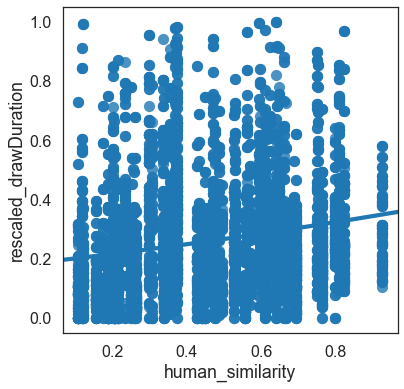

In [64]:
cost_metric = 'rescaled_drawDuration' ## cost metrics options: 'num_strokes','mean_intensity','drawDuration'
fig = plt.figure(figsize=(6,6))
sns.regplot(data=X,
           x='human_similarity', ## similarity
           y=cost_metric,
           robust=False,
           ci=None,
           logistic=True)

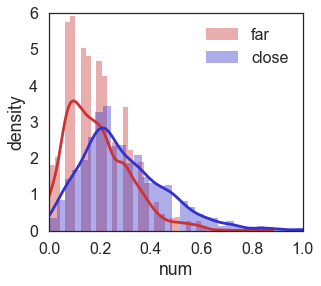

In [128]:
metric = 'rescaled_num_strokes'
f = X[X['condition']=='further'][metric].values
c = X[X['condition']=='closer'][metric].values

fig = plt.figure(figsize=(10,4))
plt.subplot(121)
h = sns.distplot(f,color=[0.8,0.2,0.2],label='far')
h = sns.distplot(c,color=[0.2,0.2,0.8],label='close')
plt.ylim([0,6])
plt.legend()
plt.xlim([0,1])
plt.xlabel(metric.split('_')[1])
plt.ylabel('density')
plt.savefig('./plots/cost_density_by_condition_{}.pdf'.format(metric.split('_')[1]))

In [85]:
## resave out csv, augmented with rescaled cost parameters
X.to_csv('./sketchpad_basic_recog_group_data_augmented.csv')

(0.44041704579870206, 1.005695e-318)
(0.7315269324734833, 0.0)
(0.43773086019766433, 1.959682411e-314)
(0.25089869687038463, 1.5885656580728161e-97)
(0.2517329567272079, 3.4908139372962754e-98)
(0.18842286496544275, 4.767883868014455e-55)


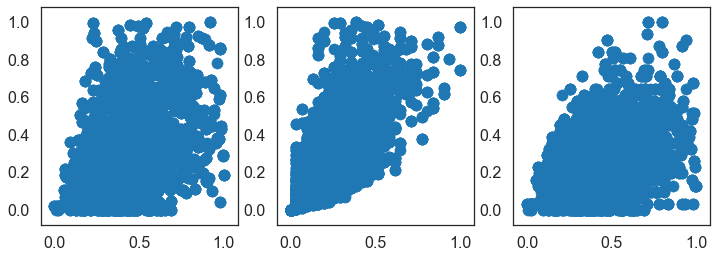

In [91]:
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.scatter(X['rescaled_mean_intensity'],X['rescaled_drawDuration'])
plt.subplot(132)
plt.scatter(X['rescaled_num_strokes'],X['rescaled_drawDuration'])
plt.subplot(133)
plt.scatter(X['rescaled_mean_intensity'],X['rescaled_num_strokes'])

print stats.pearsonr(X['rescaled_mean_intensity'],X['rescaled_drawDuration'])
print stats.pearsonr(X['rescaled_num_strokes'],X['rescaled_drawDuration'])
print stats.pearsonr(X['rescaled_mean_intensity'],X['rescaled_num_strokes'])

print stats.pearsonr(X['rescaled_mean_intensity'],X['human_similarity'])
print stats.pearsonr(X['rescaled_num_strokes'],X['human_similarity'])
print stats.pearsonr(X['rescaled_drawDuration'],X['human_similarity'])

In [93]:
## generate cost dictionaries to try out with pragmatics model
print len(np.unique(X['sketchID'].values))
sketchID_list = np.unique(X['sketchID'].values)
metrics = ['drawDuration','mean_intensity','num_strokes']

for metric in metrics:    
    print metric
    #### draw duration
    cost_json = {}
    for i,d in enumerate(sketchID_list):
        assert len(np.unique(X[X['sketchID']==d]['rescaled_{}'.format(metric)].values))==1
        cost_json[d] = X[X['sketchID']==d]['rescaled_{}'.format(metric)].values[0]    

    ## output json in the same format as the other cost json
    output_path = '../models/refModule/json/costs-fixedPose96-{}.json'.format(metric)
    with open(output_path, 'wb') as fp:
        json.dump(cost_json, fp)
        

2739
drawDuration
mean_intensity
num_strokes


In [140]:
u = load_json('../models/refModule/json/costs-fixedPose96-drawDuration.json')

In [141]:
len(u)

2739

### Get MAP param values from bdaOutput

In [332]:
path_to_bdaoutput = '../models/bdaOutput'

In [333]:
marp = 'combined_MCMC_human_wcostParamsParams.csv'
x = pd.read_csv(os.path.join(path_to_bdaoutput,marp))
x

,perception,pragmatics,production,alpha,simScaling,pragWeight,costWeight,logLikelihood,posteriorProb
0,human,combined,cost,7.718221,9.978592,0.996868,0.142434,-4105.19673,0


In [334]:
marp = 'S1_MCMC_human_wcostParamsParams.csv'
x = pd.read_csv(os.path.join(path_to_bdaoutput,marp))
x

,perception,pragmatics,production,alpha,simScaling,pragWeight,costWeight,logLikelihood,posteriorProb
0,human,S1,cost,7.443431,9.993814,1,0.127251,-4104.526485,0


## Explore model predictions and do model comparison

In [143]:
def sumlogprob(a,b):
    if (a > b):
        return a + np.log1p(np.exp(b-a))
    else:
        return b + np.log1p(np.exp(a-b))  
    
dogs = sorted(['weimaraner', 'chihuahua', 'basset', 'doberman', 'bloodhound', 'bullmastiff', 'goldenretriever', 'pug'])
chairs = sorted(['leather', 'straight', 'squat', 'sling', 'woven', 'waiting', 'inlay','knob'])
birds = sorted(['crow', 'pigeon', 'robin', 'sparrow', 'tomtit', 'nightingale', 'bluejay', 'cuckoo'])
cars = sorted(['beetle', 'bluesport', 'brown', 'white', 'redsport', 'redantique', 'hatchback', 'bluesedan'])

In [144]:
path_to_bda_output = '../models/bdaOutput'

In [249]:
## load in predictives for combined model where the cost is measured in rescaled_drawDuration
menu_predictives = ['drawDurationPredictives.csv']
predictives = pd.read_csv(os.path.join(path_to_bda_output,'drawDurationPredictives.csv'))

### various preprocessing
predictives = predictives.drop(columns=['asdf','trueSketch'],axis=1) ## remove some columns
predictives = predictives.rename(index=str,columns={'coarseGrainedTrueSketch':'trueSketch','coarseGrainedPossibleSketch':'predSketch'})
predictives['trueCondition'], predictives['trueSketchTarget'] = predictives['trueSketch'].str.split('_', 1).str
predictives['predCondition'], predictives['predSketchTarget'] = predictives['predSketch'].str.split('_', 1).str

In [250]:
## get dataframe with probability assigned to every sketch category, for each sketch category
P = predictives.groupby(['trueSketch','predSketch'])['modelProb'].\
apply(lambda x: reduce(sumlogprob,x) - np.log(len(x)))

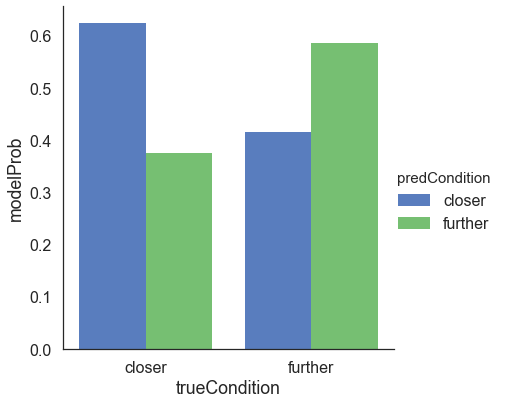

In [254]:
## coarse aggregation: higher probability assigned to true condition than false?
P = predictives.groupby(['trueSketch', 'trueCondition', 'predCondition'])['modelProb'].\
apply(lambda x: reduce(sumlogprob,x) - np.log(len(x))).\
groupby(['trueCondition','predCondition']).\
apply(lambda x: np.sum(np.exp(x)))

## plot it
Y = pd.DataFrame(P)
Y.reset_index(inplace=True)
g = sns.factorplot(x="trueCondition", 
                   y="modelProb", 
                   hue="predCondition", 
                   data=Y,
                   size=6, kind="bar", palette="muted")

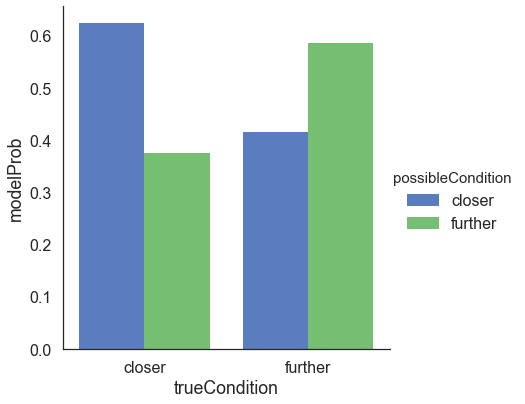

In [248]:
g = sns.factorplot(x="trueCondition", 
                   y="modelProb", 
                   hue="possibleCondition", 
                   data=Y,
                   size=6, kind="bar", palette="muted")